<center> <span style="color:indigo">Machine Learning e Inferencia Bayesiana</span> </center> 

<div style="text-align: center;">
<img src="../Imagenes/CUGDL_logo.png" alt="Drawing" style="width: 800px;"/>
</div>

<center> <span style="color:DarkBlue">  Tema 7. Árboles de Decisión: Implementación</span>  </center>
<center> <span style="color:Blue"> Profesor: M. en C. Iván A. Toledano Juárez </span>  </center>

## Árboles de decisión para clasificación

Los árboles de decisión son uno de los modelos más intuitivos y visuales en *Machine Learning*. Se construyen haciendo preguntas secuenciales sobre las características de los datos, de forma que cada división o “rama” intenta separar las clases de la mejor manera posible. Por ejemplo, al clasificar flores *Iris*, el árbol podría comenzar preguntando: **"¿el largo del pétalo es mayor a 2.5 cm?"**. Según la respuesta (sí o no), el árbol divide el conjunto y continúa generando nuevas preguntas en cada nodo hasta llegar a una predicción.

El objetivo del árbol es construir una estructura en la que las hojas (los nodos terminales) contengan observaciones lo más puras posible, es decir, que pertenezcan en su mayoría a una sola clase. Para decidir cómo dividir los datos en cada nodo, el algoritmo evalúa medidas de **impureza** o **desorden**.

### Medidas de impureza: Gini y Entropía

Dos de las medidas más comunes para cuantificar la impureza en clasificación son el **índice de Gini** y la **entropía**.

- **Índice de Gini**: mide la probabilidad de clasificar incorrectamente un elemento si se asigna aleatoriamente según la distribución de clases en ese nodo. Se calcula como:

\begin{equation}
G = 1 - \sum_{k=1}^{K} p_k^2
\end{equation}

donde $p_k$ es la proporción de ejemplos de la clase $k$ en el nodo. Un nodo es puro cuando $G = 0$.

- **Entropía**: proviene de la teoría de la información y mide el nivel de incertidumbre o aleatoriedad. Es un poco más sensible a clases menos frecuentes. Se calcula como:

\begin{equation}
H = - \sum_{k=1}^{K} p_k \log_2(p_k)
\end{equation}

En ambos casos, el valor es mínimo cuando el nodo es puro (todas las observaciones pertenecen a una sola clase) y máximo cuando las clases están balanceadas. Durante el entrenamiento, el algoritmo evalúa todas las posibles divisiones y elige aquella que **maximiza la ganancia de información** o **reduce más la impureza total**.

### ¿Por qué usar árboles?

Los árboles de decisión son fáciles de visualizar, interpretar y explicar. Cada predicción puede trazarse como una secuencia de reglas lógicas. Sin embargo, pueden volverse muy complejos y sobreajustarse a los datos de entrenamiento si no se regulan adecuadamente. Para evitarlo, es común limitar la **profundidad del árbol**, el **número mínimo de muestras por división**, o usar técnicas de *poda* para simplificar su estructura.

En este notebook entrenaremos un árbol de decisión con el dataset *Iris*, y exploraremos cómo toma decisiones, qué tan bien generaliza y cómo visualizar su estructura de manera gráfica.


In [1]:
# Importación de librerías
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, accuracy_score, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import KFold, cross_val_score

# Graphviz para visualizar el árbol
from graphviz import Source

## Carga de datos

In [2]:
iris = load_iris() # Cargar el dataset, iris.data = Matriz de features, iris.target = clases objetivo (numericas), iris.target_names = clases objetivo (strings)
df_iris = pd.DataFrame(data=iris.data, columns=iris.feature_names) # Convertirlo a DataFrame
df_iris['Species'] = iris.target # Agregar la columna de la variable objetivo
df_iris['Species'] = df_iris['Species'].map(dict(enumerate(iris.target_names))) # Para que las clases aparezcan como texto
df_iris.head(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [3]:
# La lista de targets ya está precargada en los dataset de ejemplo de scikitlearn
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [4]:
df_iris.shape

(150, 5)

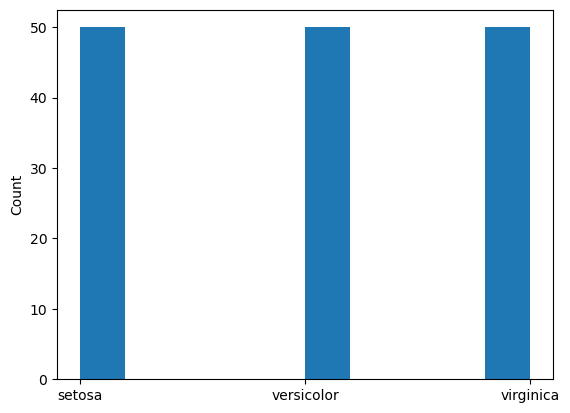

In [5]:
# Tenemos los mas homogeneo posible, pues todas las clases tienen la misma estadística
plt.hist(df_iris['Species'])
plt.ylabel('Count')
plt.show()

In [6]:
## Variables predictoras y objetivo
col_names = df_iris.columns.values.tolist()

X = df_iris[col_names[:4]]
y = df_iris[col_names[4]]

In [7]:
X

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [8]:
y

0         setosa
1         setosa
2         setosa
3         setosa
4         setosa
         ...    
145    virginica
146    virginica
147    virginica
148    virginica
149    virginica
Name: Species, Length: 150, dtype: object

## División de conjunto de entrenamiento y validacion

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=1)

In [10]:
X_train

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
118,7.7,2.6,6.9,2.3
18,5.7,3.8,1.7,0.3
4,5.0,3.6,1.4,0.2
45,4.8,3.0,1.4,0.3
59,5.2,2.7,3.9,1.4
...,...,...,...,...
133,6.3,2.8,5.1,1.5
137,6.4,3.1,5.5,1.8
72,6.3,2.5,4.9,1.5
140,6.7,3.1,5.6,2.4


In [11]:
y_train

118     virginica
18         setosa
4          setosa
45         setosa
59     versicolor
          ...    
133     virginica
137     virginica
72     versicolor
140     virginica
37         setosa
Name: Species, Length: 105, dtype: object

## Implementacion con Python y Scikit-Learn

Al igual que con la regresión logística, usaremos la biblioteca `scikit-learn` para entrenar y evaluar nuestro modelo. Esta biblioteca nos permite aplicar árboles de decisión de forma muy sencilla, con una interfaz consistente que ya conocemos: creamos un modelo, lo entrenamos con `.fit()`, predecimos con `.predict()` y evaluamos su desempeño con métricas como la exactitud o la matriz de confusión.

En este caso, utilizaremos el clasificador `DecisionTreeClassifier`, que implementa el algoritmo de árboles de decisión para tareas de clasificación. A través de sus parámetros, podremos controlar aspectos como la profundidad máxima del árbol, el criterio de impureza (`gini` o `entropy`) o el número mínimo de muestras por nodo. Veremos que, aunque la estructura del código es parecida a la que usamos antes, el modelo que obtenemos se comporta de forma distinta y tiene ventajas y desventajas particulares que iremos analizando.

In [12]:
# 1. Instanciamos el modelo y sus hiperparámetros
## criterion='entropy' utiliza algoritmo ID3
tree = DecisionTreeClassifier(criterion='entropy',
                              min_samples_split=20,# numero minimo de elementos para llevar a cabo una division (default 2)
                              random_state=1,
                              min_samples_leaf=3) # numero de elementos para ser considerado hoja (default 1)

# 2. Entrenamos con el conjunto de entrenamiento
tree.fit(X_train, y_train)

# 3. Predicciones de clases y evaluación básica
y_pred = tree.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")

# 4. Predicciones con probabilidades predichas
# Probabilidades para ROC y AUC
y_prob = tree.predict_proba(X_test) # Aquí hacemos una modificación, incluimos las probabilidades de todas las clases

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Reportes detallados (incluye precisión, recall y F1)
print("=== Reporte modelo completo ===")
print(classification_report(y_test, y_pred))

# AUC
auc = roc_auc_score(y_test, y_prob, multi_class='ovr') # multi_class = "one vs rest"
print(f"auc-score: {auc:.4f}")

Accuracy: 0.9556
=== Reporte modelo completo ===
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        14
  versicolor       0.94      0.94      0.94        18
   virginica       0.92      0.92      0.92        13

    accuracy                           0.96        45
   macro avg       0.96      0.96      0.96        45
weighted avg       0.96      0.96      0.96        45

auc-score: 0.9665


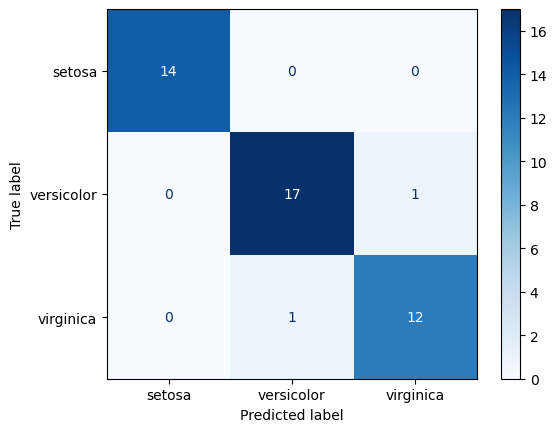

In [13]:
# Visualización de matriz de confusión

# Creamos el gráfico a partir de la matriz ya calculada
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=iris.target_names)

# Dibujamos el gráfico
disp.plot(cmap='Blues')  # Puedes cambiar el mapa de color si lo deseas

plt.show()

#### ¿Por qué usamos la curva ROC en clasificación multiclase?

La curva ROC (Receiver Operating Characteristic) es una herramienta clásica para evaluar modelos de clasificación **binaria**, ya que permite visualizar el compromiso entre la **tasa de verdaderos positivos** (TPR) y la **tasa de falsos positivos** (FPR) para diferentes umbrales de decisión.

Sin embargo, en el caso de problemas de **clasificación multiclase**, como el dataset *Iris* que contiene tres especies diferentes, no es posible construir una única curva ROC directamente. Para resolver esto, aplicamos una estrategia conocida como **One-vs-Rest (OvR)**, donde consideramos cada clase por separado como la "clase positiva" y agrupamos las demás como "clase negativa". De este modo, generamos una curva ROC para cada clase de forma individual, lo que permite analizar cómo se comporta el modelo al distinguir cada una de ellas contra las demás.

En `scikit-learn`, esta estrategia está incorporada y facilita la evaluación multiclase mediante curvas ROC por clase. Puedes consultar un ejemplo completo y oficial en la documentación de `scikit-learn`:  
[https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html)

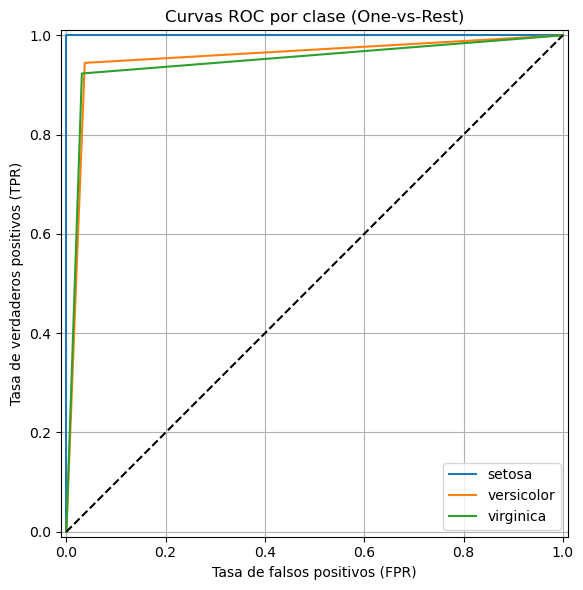

In [14]:
# Curva de ROC multiclase
# Si binarizan las clases verdaderas con forma One-vs-Rest
y_test_bin = label_binarize(y_test, classes=iris.target_names)

# Número de clases
n_classes = y_test_bin.shape[1]

# Graficamos una curva ROC por cada clase
plt.figure(figsize=(8, 6))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name=iris.target_names[i]).plot(ax=plt.gca())

plt.plot([0, 1], [0, 1], 'k--')
plt.title("Curvas ROC por clase (One-vs-Rest)")
plt.xlabel("Tasa de falsos positivos (FPR)")
plt.ylabel("Tasa de verdaderos positivos (TPR)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


## Representación gráfica del árbol

Una de las principales ventajas de los árboles de decisión es que pueden representarse de forma gráfica, lo que permite **visualizar cómo el modelo toma decisiones** a través de una secuencia de reglas. Para ello, podemos utilizar la función `export_graphviz` de `scikit-learn`, que genera un archivo en formato `.dot`, y posteriormente convertirlo a una imagen con la biblioteca `graphviz`. El objeto dot de Scikitlearn contiene la información de los nodos y ramas del árbol, y les recomiendo echarle un ojo a cómo está estructurado.

Esta visualización muestra cada nodo con la condición utilizada para dividir los datos, el número de muestras que llegan a ese nodo, la distribución de clases y, finalmente, la clase asignada en las hojas. Es especialmente útil para interpretar el modelo y detectar posibles sobreajustes si el árbol crece demasiado.

A continuación, exportaremos el árbol entrenado y lo visualizaremos como imagen. Es importante tener instalado el paquete `graphviz` de Python, que nos permitirá mostrar el árbol directamente dentro del notebook.

In [15]:
# Sintaxis (file, tipo de apertura) 
# Si trabajas con un fichero, acordarse de cerrarlo

with open("iris_dtree.dot", 'w') as dotfile:
    export_graphviz(tree, out_file=dotfile, feature_names=X_train.columns)
    dotfile.close()

In [16]:
file = open("iris_dtree.dot", "r")
text = file.read()

In [17]:
# Se imprime el texto que contiene el archivo .dot que acabamos de generar
text

'digraph Tree {\nnode [shape=box, fontname="helvetica"] ;\nedge [fontname="helvetica"] ;\n0 [label="petal width (cm) <= 0.8\\nentropy = 1.582\\nsamples = 105\\nvalue = [36, 32, 37]"] ;\n1 [label="entropy = 0.0\\nsamples = 36\\nvalue = [36, 0, 0]"] ;\n0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;\n2 [label="petal width (cm) <= 1.65\\nentropy = 0.996\\nsamples = 69\\nvalue = [0, 32, 37]"] ;\n0 -> 2 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;\n3 [label="petal length (cm) <= 5.0\\nentropy = 0.431\\nsamples = 34\\nvalue = [0, 31, 3]"] ;\n2 -> 3 ;\n4 [label="entropy = 0.0\\nsamples = 30\\nvalue = [0, 30, 0]"] ;\n3 -> 4 ;\n5 [label="entropy = 0.811\\nsamples = 4\\nvalue = [0, 1, 3]"] ;\n3 -> 5 ;\n6 [label="petal length (cm) <= 4.85\\nentropy = 0.187\\nsamples = 35\\nvalue = [0, 1, 34]"] ;\n2 -> 6 ;\n7 [label="entropy = 0.811\\nsamples = 4\\nvalue = [0, 1, 3]"] ;\n6 -> 7 ;\n8 [label="entropy = 0.0\\nsamples = 31\\nvalue = [0, 0, 31]"] ;\n6 -> 8 ;\n}'

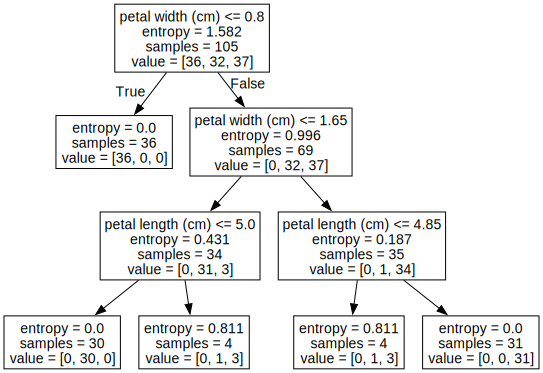

In [18]:
Source(text)

## Validación y poda del árbol de decisión

Aunque los árboles de decisión son modelos muy interpretables, tienen una gran **tendencia al sobreajuste** (*overfitting*) si se les permite crecer sin restricciones. Un árbol muy profundo puede aprenderse de memoria el conjunto de entrenamiento, pero generalizar mal a nuevos datos. Por eso, es importante validar su desempeño utilizando un conjunto de prueba o técnicas como la **validación cruzada**, para detectar cuándo un árbol comienza a memorizar en lugar de aprender patrones generales.

Una forma común de prevenir este sobreajuste es aplicar lo que se conoce como **poda** (*pruning*), que consiste en limitar o reducir el tamaño del árbol. Esto se puede hacer de manera preventiva (**poda previa**, *pre-pruning*) ajustando hiperparámetros como `max_depth`, `min_samples_split` o `min_samples_leaf`, que controlan cuán grande puede llegar a ser el árbol. También existe la **poda posterior** (*post-pruning*), en la que el árbol se entrena completamente y luego se eliminan ramas poco informativas con base en el rendimiento en validación.

En esta sección, exploraremos cómo regular el tamaño del árbol mediante poda previa, y cómo evaluar el impacto de estas decisiones sobre el rendimiento del modelo.

In [19]:
# Validacion cruzada 

# 1. se instancia la forma de validación (en este caso, validacion cruzada kfold)
cv = KFold(n_splits=50, shuffle=True, random_state=1) # shuffle para que haga un muestreo aleatorio antes

# 2. se aplica la validación
# En este caso, utilizamos la métrica accuracy como referencia
score = (cross_val_score(tree,X,y,scoring='accuracy', cv=cv, n_jobs=1))

print('score: ', score)

score:  [1.         1.         1.         1.         1.         1.
 1.         0.66666667 1.         1.         1.         1.
 1.         1.         0.66666667 1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         0.66666667 1.
 1.         1.         1.         1.         1.         1.
 1.         1.         0.66666667 0.66666667 1.         1.
 1.         1.         1.         1.         1.         0.33333333
 1.         1.        ]


Por la misma naturaleza de estos datos de ejemplo Iris, y por la forma en cómo está estructurada la información, vamos a tener mucho score=1.0 en la exactitud. Por lo mismo, en este caso, no te preocupes mucho en los casos donde el accuracy baja mucho.

A continuación, vamos a explorar qué pasa si vamos cambiando uno de los hiperparámetros del modelo `max_depth` para la poda del árbol, y cómo éste afecta la métrica.

In [20]:
for i in range(1,11):

    # Instanciamos modelo
    tree = DecisionTreeClassifier(criterion='entropy',
                              max_depth=i,
                              min_samples_split=20,
                              random_state=99)

    # Entrenamiento con todos lo datos, para hacer validación cruzada
    tree.fit(X,y)

    # 3. Validación cruzada
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    scores = cross_val_score(tree,X,y,scoring='accuracy', cv=cv, n_jobs=1)
    score = np.mean(scores)
    
    print('Score para max depth =', i, '=', score)

Score para max depth = 1 = 0.5666666666666667
Score para max depth = 2 = 0.9200000000000002
Score para max depth = 3 = 0.9400000000000001
Score para max depth = 4 = 0.9333333333333333
Score para max depth = 5 = 0.9333333333333333
Score para max depth = 6 = 0.9333333333333333
Score para max depth = 7 = 0.9333333333333333
Score para max depth = 8 = 0.9333333333333333
Score para max depth = 9 = 0.9333333333333333
Score para max depth = 10 = 0.9333333333333333


Aquí, podemos observar que:

- Con una profundidad muy baja (`max_depth = 1`), el modelo es **demasiado simple** y no captura bien la estructura del problema, lo que resulta en una precisión promedio baja (~56.7%). Esto es un claro caso de **subajuste** (*underfitting*).
- Al aumentar la profundidad a 2 o 3, el modelo mejora notablemente su precisión, alcanzando un rendimiento óptimo cercano al 94%. A partir de `max_depth = 3`, la precisión **ya no mejora significativamente**, y se mantiene constante en torno al 93.3% para valores mayores.
- Esto sugiere que a partir de cierto punto, aumentar la profundidad del árbol **no aporta beneficio adicional** y puede incluso aumentar el riesgo de sobreajuste sin mejorar la generalización.

En resumen, este tipo de validación nos permite encontrar un **punto de equilibrio**: una profundidad suficientemente expresiva para aprender los patrones relevantes, pero no tan grande como para memorizar los datos. En este caso, una buena elección para `max_depth` parece ser 3, lo cual también nos ayuda a mantener el modelo más **compacto e interpretable**.


## Rasgos de importancia

Una ventaja interesante de los árboles de decisión es que no sólo realizan predicciones, sino que también nos permiten interpretar **qué variables son más relevantes** para el modelo. Durante el entrenamiento, el árbol decide en qué características dividir basándose en cuánto ayudan a reducir la impureza (ya sea por Gini o entropía). A partir de esta información, `scikit-learn` calcula automáticamente una medida de **importancia de características**, disponible a través del atributo `.feature_importances_` del modelo entrenado.

Este atributo nos devuelve un arreglo con valores entre 0 y 1 que indican la contribución relativa de cada variable en el proceso de toma de decisiones del árbol. Cuanto mayor es la importancia de una característica, más veces se utilizó en nodos internos y mayor fue su impacto al dividir los datos y reducir la impureza.

Esta información es especialmente útil para entender el modelo y para tareas de selección de variables. En datasets multivariados como el de *Iris*, podemos visualizar qué atributos (como el largo o ancho del pétalo o sépalo) fueron los más influyentes para separar las clases. A continuación, vamos a graficar estas importancias y analizarlas con más detalle.

In [21]:
# Según el caso anterior, utilizamos un max_depth=3 para entrenar el modelo

# 1. Instanciamos el modelo y sus hiperparámetros
tree = DecisionTreeClassifier(criterion='entropy',
                              min_samples_split=20,# numero minimo de elementos para llevar a cabo una division (default 2)
                              random_state=99,
                              max_depth=3,
                              min_samples_leaf=20) # numero de elementos para ser considerado hoja (default 1)

# 2. Entrenamos con el conjunto de entrenamiento
tree.fit(X_train, y_train)

# 3. Predicciones de clases y evaluación básica
y_pred = tree.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9556


In [22]:
tree.feature_importances_

array([0.        , 0.        , 0.67194092, 0.32805908])

In [23]:
tree.feature_names_in_

array(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)'], dtype=object)

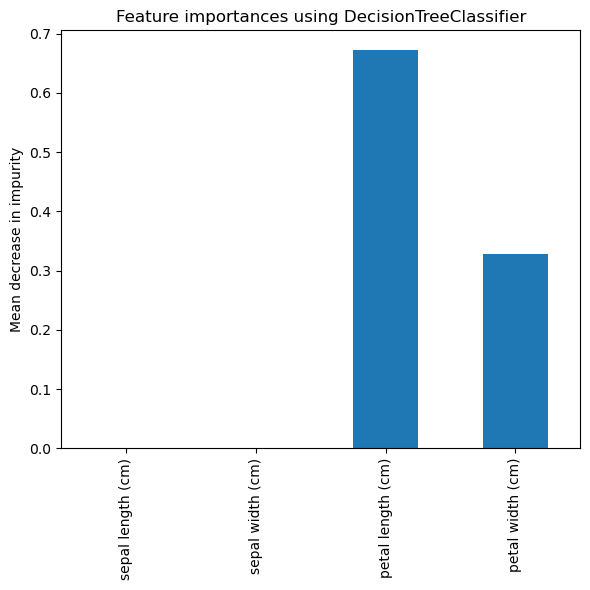

In [24]:
tree_importance = tree.feature_importances_
tree_features = tree.feature_names_in_

tree_frame = pd.Series(tree_importance, index=tree_features)

fig, ax = plt.subplots(figsize=(6,6))
tree_frame.plot.bar(ax=ax)
ax.set_title("Feature importances using DecisionTreeClassifier")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Implementación de Random Forest

Un *Random Forest* es un modelo de ensamble basado en árboles de decisión que combina **muchos árboles individuales** para lograr una predicción más robusta y precisa. En lugar de entrenar un solo árbol, como hicimos anteriormente, este método entrena **un conjunto (o bosque) de árboles**, cada uno con una muestra aleatoria distinta del conjunto de datos original. La predicción final se obtiene por **votación mayoritaria** (en clasificación) o **promedio** (en regresión), lo que reduce el riesgo de sobreajuste de los árboles individuales.

Este enfoque se conoce como **Bagging** (*Bootstrap Aggregating*), y se basa en dos ideas clave:
1. Cada árbol se entrena con una **muestra aleatoria con reemplazo** (bootstrap sample) del conjunto de entrenamiento.
2. En cada división del árbol, se considera **sólo un subconjunto aleatorio de características** (no todas), lo que introduce diversidad adicional entre los árboles.

Gracias a esta combinación de aleatoriedad y votación, las *Random Forests* suelen generalizar mejor que un árbol individual, tienen menor varianza y suelen requerir menos ajuste de hiperparámetros.

---

### Validación con Out-of-Bag (OOB) samples

Un aspecto muy útil de *Random Forest* es que permite realizar una especie de **validación cruzada automática** sin necesidad de separar un conjunto de validación. Esto se logra gracias a las **muestras OOB (Out-of-Bag)**: como cada árbol es entrenado con una muestra bootstrap (extraída con reemplazo), en promedio, alrededor del 37% de los datos **no** son seleccionados para entrenar ese árbol. Esos datos no utilizados pueden aprovecharse para evaluar el rendimiento del árbol de forma independiente.

El atributo `oob_score_` de `RandomForestClassifier` nos permite obtener el **promedio de precisión del modelo usando sólo estas muestras OOB**. Es decir, es una estimación del rendimiento general sin necesidad de hacer una validación cruzada explícita.

Además, con el método `oob_decision_function_`, se puede acceder a las **probabilidades predichas por el modelo para cada observación usando sólo los árboles que no la vieron durante el entrenamiento**. Esto nos da una forma confiable de estimar la distribución de clase para cada ejemplo, también de forma completamente *out-of-bag*.

A continuación, implementamos un modelo Random Forest sobre el dataset *Iris* para observar cómo se comporta y qué mejoras ofrece respecto a un solo árbol de decisión.


In [27]:
# 1. Instanciamos el modelo y sus hiperparámetros
forest = RandomForestClassifier(n_jobs=1, # parámetro utilizado en paralelización
                                oob_score=True,
                                n_estimators=50, # Número de árboles
                                random_state=42) 

# 2. Entrenamos con todos los datos para usar oob_score
forest.fit(X,y)

# 3. Métricas con validación OOB
print(f"OOB Score (estimación de exactitud fuera de muestra): {forest.oob_score_:.4f}")

# 4. Predicción para evaluación estándar (usamos mismo conjunto para consistencia)
y_pred_forest = forest.predict(X)

OOB Score (estimación de exactitud fuera de muestra): 0.9667


In [84]:
forest.oob_decision_function_ 
## La mayoría de clase por modelo
## es la mayoría de clases para hacer la clasificacion final

array([[1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.


=== Evaluación con todo el dataset ===
Accuracy: 1.0000
Matriz de confusión:


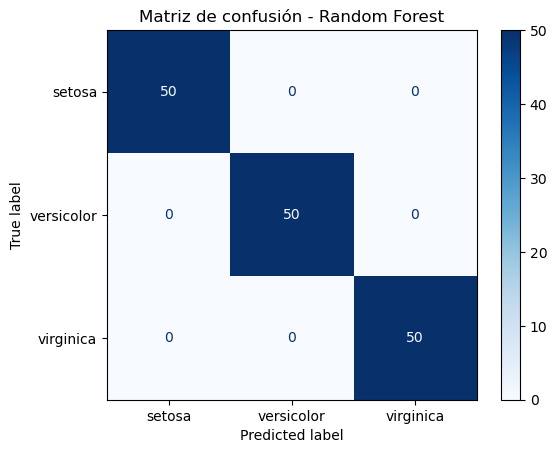


Reporte de clasificación:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        50
  versicolor       1.00      1.00      1.00        50
   virginica       1.00      1.00      1.00        50

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



In [30]:
# 5. Evaluación del rendimiento
print("\n=== Evaluación con todo el dataset ===")
print(f"Accuracy: {accuracy_score(y, y_pred_forest):.4f}")
print("Matriz de confusión:")
ConfusionMatrixDisplay.from_estimator(forest, X, y, display_labels=iris.target_names, cmap='Blues')
plt.grid(False)
plt.title("Matriz de confusión - Random Forest")
plt.show()

print("\nReporte de clasificación:")
print(classification_report(y, y_pred_forest, target_names=iris.target_names))

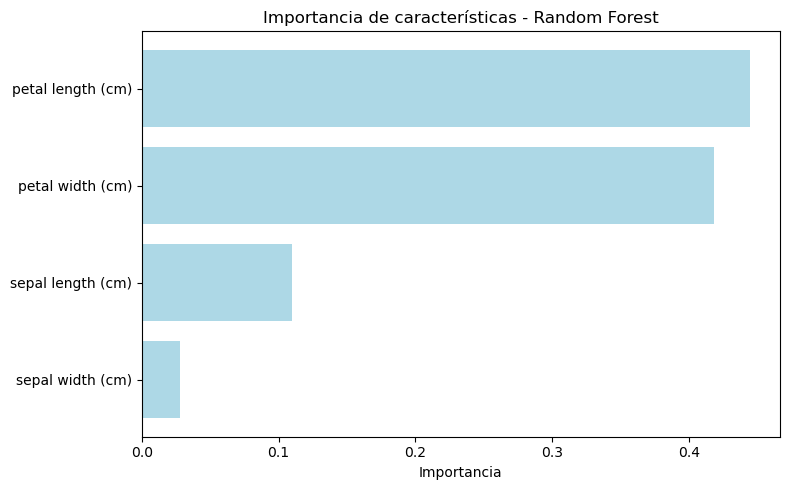

In [34]:
# 6. Importancia de características
importances = forest.feature_importances_
feature_names = forest.feature_names_in_

# Crear DataFrame para ordenar y visualizar
df_importance = pd.DataFrame({'feature': feature_names, 'importance': importances})
df_importance = df_importance.sort_values(by='importance', ascending=False)

# Visualización
plt.figure(figsize=(8,5))
plt.barh(df_importance['feature'], df_importance['importance'], color='lightblue')
plt.xlabel("Importancia")
plt.title("Importancia de características - Random Forest")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Resumen y conclusiones

En este notebook exploramos a fondo los árboles de decisión como modelo base para tareas de clasificación, aplicándolos al dataset *Iris*. Aprendimos cómo funcionan internamente, cómo toman decisiones mediante divisiones jerárquicas, y cómo evaluar su desempeño utilizando métricas como la exactitud, la matriz de confusión y la curva ROC. Vimos que, aunque los árboles individuales son interpretables y rápidos de entrenar, también pueden ser propensos al sobreajuste si no se controlan adecuadamente. Por ello, analizamos estrategias como la **poda** y la validación cruzada para ajustar su complejidad.

Posteriormente, introdujimos el modelo de **Random Forest**, que combina múltiples árboles entrenados sobre subconjuntos aleatorios de datos y características. Observamos que este enfoque reduce la varianza, mejora la generalización y permite además realizar una validación interna a través de las **muestras out-of-bag (OOB)**. Esta validación automática aporta una estimación del rendimiento sin necesidad de usar un conjunto de prueba separado, lo que lo hace especialmente útil en contextos con pocos datos.

En conclusión, los árboles de decisión son una excelente herramienta de aprendizaje automático supervisado, y el modelo Random Forest representa una evolución natural que mejora su estabilidad y precisión sin perder interpretabilidad. Ambos modelos nos brindan, además, información valiosa sobre la importancia relativa de las variables, lo que facilita su análisis y comprensión.